# Code for fitting Astero RC data

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib
sns.set_palette('colorblind',20)
sns.set_context('notebook')
matplotlib.rc('xtick', labelsize=15) 
matplotlib.rc('ytick', labelsize=15)
matplotlib.rc('axes',labelsize=15) 
import pandas as pd
import pystan

import os
import pickle

els = False

import sys

In [2]:
def read_data(data_file=''):
    if data_file == '':
        sfile = '../data/KepxDR2/rcxyu18.csv'
    elif data_file != '':
        sfile = data_file
    df = pd.read_csv(sfile)
    return df

def normal(x, mu, sigma):
    return (1/np.sqrt(2*np.pi*sigma**2)) * np.exp(-(x - mu)**2/(2*sigma**2))

In [3]:
df = read_data()
print('Size: '+str(len(df)))
df.head(2)

Size: 5578


,KICID,kepmag_x,Length_Quarters,Length_days,numax,numax_err,dnu,dnu_err,amplitude,err.2_x,...,BC_GBP,BC_GRP,BC_J,BC_H,BC_K,ast_MKs,ast_MH,ast_MJ,ast_MG,ast_M_err
0,892760,13.23,6,380.8,29.48,0.48,3.962,0.116,149.7,8.3,...,-0.740,0.388,1.206,1.638,1.766,-1.671046,-1.543046,-1.111046,0.343954,0.206767
1,1026084,12.14,15,1139.0,41.17,0.90,4.414,0.061,63.8,2.9,...,-0.754,0.409,1.252,1.706,1.840,-1.878376,-1.744376,-1.290376,0.205624,0.166498


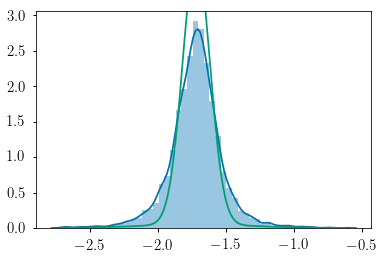

-1.7181408971464607


In [4]:
'''Step one is figuring out the different distributions we want'''
df.head(2)
Ks = df.ast_MKs.values
x = np.linspace(Ks.min(),Ks.max(),1000)

rQ = 0.95
rmu = np.median(Ks)
rsigma = .1
rsigo = 4.*rsigma

rfg = normal(x, rmu, rsigma)
rbg = normal(x, rmu, rsigo)
pp = rQ*rfg + (1-rQ)*rbg

sns.distplot(Ks, label='Observed')
plt.plot(x,pp, label='Likelihood')
plt.show()

print(np.median(Ks))

## Stan model for asteroseismic values

In [5]:
overwrite = True
asterostan = '''
data {
    int<lower = 0> N;
    real Mobs[N];
    real Munc[N];
}
parameters {
    //Hyperparameters
    real mu;
    real <lower=0.> sigma;
    real <lower=0.5,upper=1.> Q;
    real <lower=1.> sigo;

    //Latent Parameters
    real Mtrue_std[N];
}
transformed parameters{
    real Mtrue[N];
    
    for (n in 1:N){
        Mtrue[n] = mu + sigma * Mtrue_std[n];
    }
}
model {
    mu ~ normal(-1.6, 1.0);  //p(theta)
    sigma ~ normal(0.0, 1.0); //''
    sigo ~ normal(3.0, 2.0);  //''
    Q ~ normal(1., 0.1);    //''  
    
    Mobs ~ normal(Mtrue, Munc); //p(D | theta, alpha)
    
    //p(alpha | theta)
    for (n in 1:N)
        target += log_mix(Q,
                    normal_lpdf(Mtrue_std[n] | 0., 1.),
                    normal_lpdf(Mtrue_std[n] | 0., sigo));
}
'''
model_path = 'asterostan.pkl'
if overwrite:
    print('Updating Stan model')
    sm = pystan.StanModel(model_code = asterostan, model_name='asterostan')
    with open(model_path, 'wb') as f:
        pickle.dump(sm, f)
else:
    if os.path.isfile(model_path):
        print('Loading in existing Stan Model') 
        sm = pickle.load(open(model_path, 'rb'))
    else:
        print('Saving Stan Model') 
        sm = pystan.StanModel(model_code = asterostan, model_name='asterostan')
        with open(model_path, 'wb') as f:
            pickle.dump(sm, f)

Updating Stan model


INFO:pystan:COMPILING THE C++ CODE FOR MODEL asterostan_be811a2cbd49d7892c7c2f856d4b7b3d NOW.


In [16]:
sel = df[:1000]
Mobs = sel.ast_MKs
Munc = sel.ast_M_err.values
m = sel.Kmag.values
dat = {'N': len(sel),
      'Mobs': Mobs,
      'Munc' : Munc}

init = {'mu': rmu,
       'sigma': rsigma,
        'Q': rQ,
       'sigo': rsigo/rsigma}
fit = sm.sampling(data=dat, iter=10000, chains=4, init=[init,init,init,init])

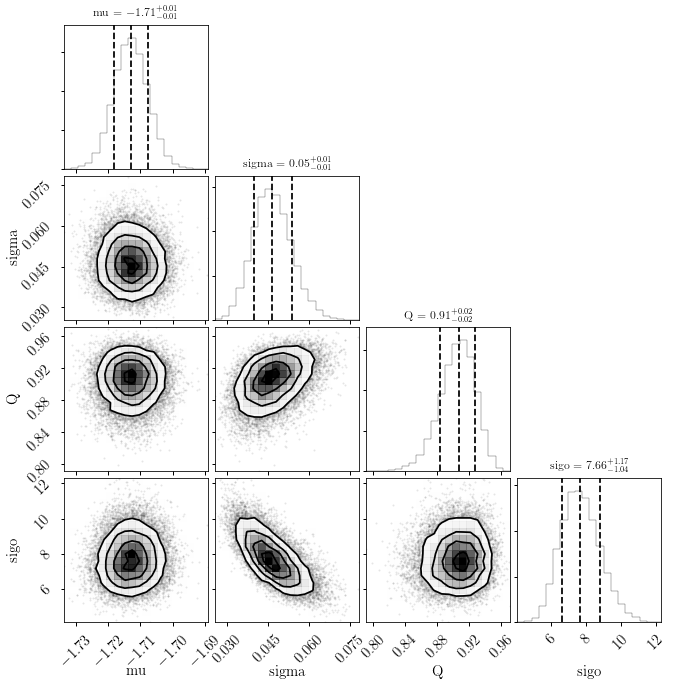

In [17]:
import corner
chain = np.array([fit['mu'],fit['sigma'],fit['Q'],fit['sigo']])
corner.corner(chain.T,labels=['mu','sigma','Q','sigo'],
                  quantiles=[0.16, 0.5, 0.84],\
                  show_titles=True, title_kwargs={"fontsize": 12})
plt.show()

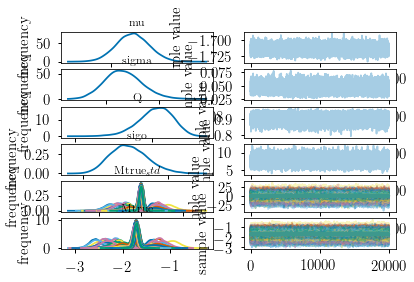

In [18]:
fit.plot()
plt.show()

In [19]:
print(fit)

Inference for Stan model: asterostan_be811a2cbd49d7892c7c2f856d4b7b3d.
4 chains, each with iter=10000; warmup=5000; thin=1; 
post-warmup draws per chain=5000, total post-warmup draws=20000.

                 mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu              -1.71  3.7e-5 5.3e-3  -1.72  -1.72  -1.71  -1.71   -1.7  20000    1.0
sigma            0.05  3.2e-4 7.1e-3   0.03   0.04   0.05   0.05   0.06  501.0   1.01
Q                0.91  8.9e-4   0.02   0.86   0.89   0.91   0.92   0.94  633.0   1.01
sigo             7.73    0.03   1.11   5.76   6.94   7.66   8.45  10.08 1544.0    1.0
Mtrue_std[0]     0.07    0.02   1.37  -2.13  -0.63   0.05   0.73   2.39 6514.0    1.0
Mtrue_std[1]    -0.43    0.02   1.39   -3.8   -1.0   -0.3   0.37   1.65 4966.0    1.0
Mtrue_std[2]    -0.84    0.03   1.89  -6.83  -1.28  -0.53   0.16   1.46 3146.0    1.0
Mtrue_std[3]     0.23    0.03    1.9  -2.24   -0.6   0.11   0.85   4.34 3117.0    1.0
Mtrue_std[4]     0.57  8.5e-3    1.

[0.99999577 1.00725071 1.00803324 ... 1.0003816  1.00004349 1.01251391]
Total number of Rhats: 2005
Total number of Rhats with the NaN values removed: 2005


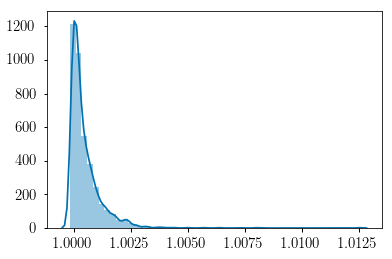

In [20]:
s = fit.summary()
print(s['summary'][:,-1])
rhat = s['summary'][:,-1]
rhatfin = rhat[np.isfinite(rhat)]
print('Total number of Rhats: '+str(len(rhat)))
print('Total number of Rhats with the NaN values removed: '+str(len(rhatfin)))
sns.distplot(rhatfin)
plt.show()

### Some diagnostic plots

In [21]:
mu = np.median(fit['mu'])
sigma = np.median(fit['sigma'])
sigo = np.median(fit['sigo'])*sigma
Q = np.median(fit['Q'])
Mtrue = np.median(fit['Mtrue'],axis=0)

x = np.linspace(Mobs.min(), Mobs.max(),1000)
fg = normal(x, mu, sigma)
bg = normal(x, mu, sigo)
L = Q*fg + (1-Q)*bg

Text(0,0.5,u'Units arbitrary')

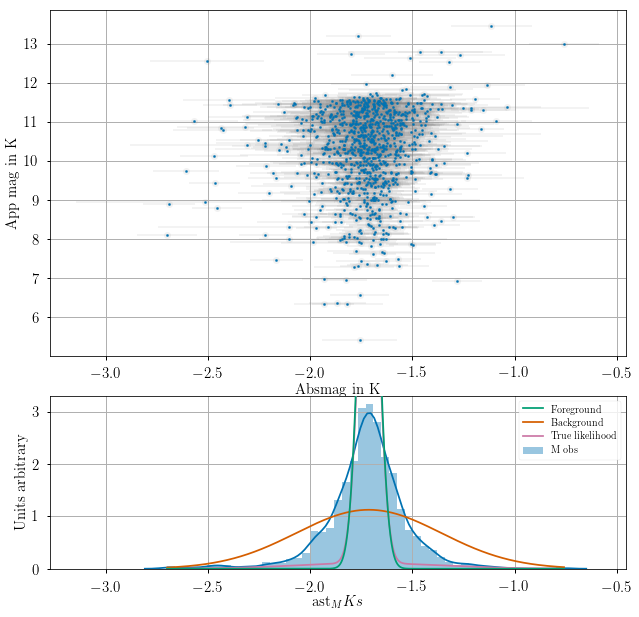

In [30]:
left, bottom, width, height = 0.1, 0.47, 1., 0.60
fig = plt.figure(1, figsize=(8,8))
sax = fig.add_axes([left, bottom, width, height])
xax = fig.add_axes([left, 0.1, width, 0.3],sharex=sax)

sax.scatter(Mobs,m,s=5,zorder=1000)
sax.errorbar(Mobs,m,xerr=Munc,c='grey',fmt='o',alpha=.1,zorder=999)

sns.distplot(Mobs, ax=xax, label='M obs')
xax.plot(x,fg,label='Foreground',zorder=999)
xax.plot(x,bg,label='Background',zorder=998)
xax.plot(x, L,label='True likelihood',zorder=997)
xax.legend()

sax.grid()
xax.grid()

sax.set_xlabel('Absmag in K')
sax.set_ylabel('App mag in K')
xax.set_ylabel('Units arbitrary')

Text(0,0.5,u'Units arbitrary')

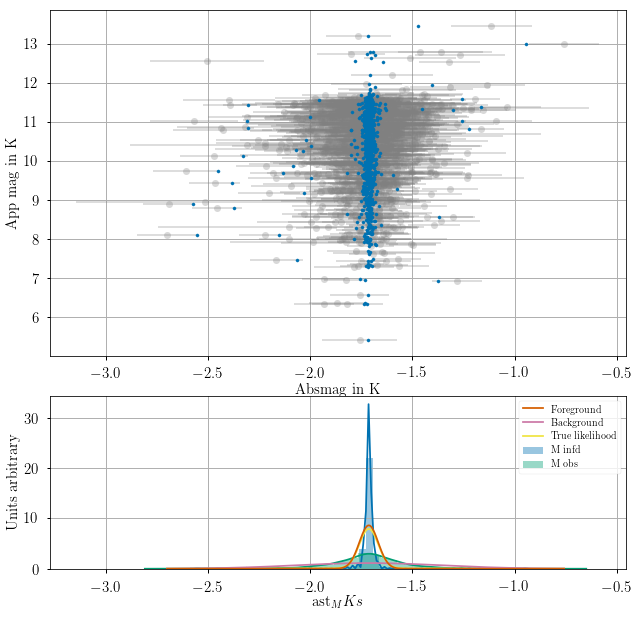

In [38]:
left, bottom, width, height = 0.1, 0.47, 1., 0.60
fig = plt.figure(1, figsize=(8,8))
sax = fig.add_axes([left, bottom, width, height])
xax = fig.add_axes([left, 0.1, width, 0.3],sharex=sax)

sax.scatter(Mtrue,m,s=10,zorder=1000)
sax.errorbar(Mobs,m,xerr=Munc,c='grey',fmt='o',alpha=.3,zorder=999)

sns.distplot(Mtrue, ax=xax, label='M infd')
sns.distplot(Mobs, ax=xax, label='M obs')
xax.plot(x,fg,label='Foreground',zorder=999)
xax.plot(x,bg,label='Background',zorder=998)
xax.plot(x, L,label='True likelihood',zorder=997)
xax.legend()

sax.grid()
xax.grid()

sax.set_xlabel('Absmag in K')
sax.set_ylabel('App mag in K')
xax.set_ylabel('Units arbitrary')

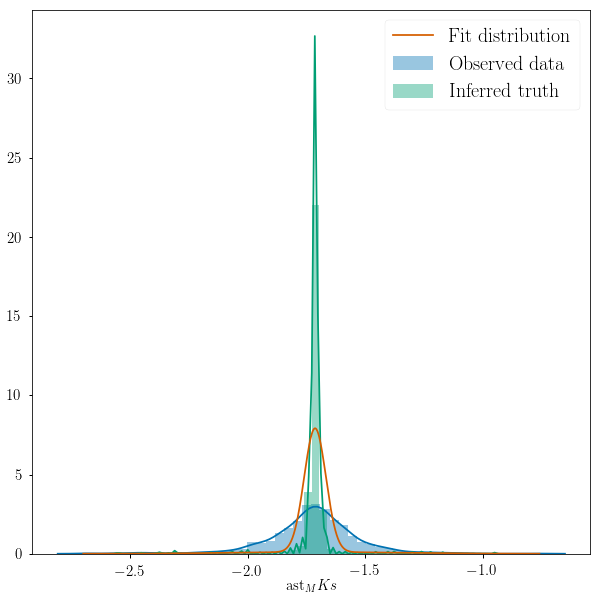

In [32]:
fig = plt.figure(figsize=(10,10))
sns.distplot(Mobs, label='Observed data')
sns.distplot(Mtrue, label='Inferred truth')
plt.plot(x, L, label='Fit distribution')
plt.legend(fontsize=20)
plt.show()

In [25]:
sys.exit()

SystemExit: 

## Other useful code

In [ ]:
'''
generated quantities {
    vector[N] post_prob;
    vector[N] bg_pp;
    real ll_fg;
    real ll_bg;
    
    for (n in 1:N){
        ll_fg = log(Q) + normal_lpdf(M_true_std[n] | 0, 1);
        ll_bg = log(1-Q) + normal_lpdf(M_true_std[n] | 0, tsigo);
        post_prob[n] = exp(ll_fg - log_sum_exp(ll_fg, ll_bg));
        bg_pp[n] = exp(ll_bg - log_sum_exp(ll_fg, ll_bg));
    }
}
'''

In [ ]:
#Calculate recall vs precision for various Kass+Raftery94 cut off scales
'''Calculate the Kass+Raftery94 lnK values'''
lnK = np.log(post_prob) - np.log(bg_pp)

recall, precision = [], []
for lim in np.linspace(lnK.min(),lnK.max(),1000):
    mask = lnK > lim
    cheb_correct = len(Ks[mask][stage[mask]==2])
    cheb_total = len(Ks[stage==2])
    identified_total = len(Ks[mask])
    recall.append(float(cheb_correct)/float(cheb_total))
    try:
        precision.append(float(cheb_correct)/float(identified_total))
    except:
        precision.append(0.)
        
fig, ax = plt.subplots()
col = ax.scatter(recall, precision, c=np.linspace(lnK.min(),lnK.max(),1000),vmin=0.)
ax.axhline(0.9,c='r',label='0.9 precision')
ax.set_xlabel('Recall')
ax.set_ylabel('Precision')
ax.grid()
ax.set_axisbelow(True)
fig.colorbar(col, label='lnK cut-off point',extend='min')
plt.show()        


In [ ]:
left, bottom, width, height = 0.1, 0.47, 0.85, 0.60
fig = plt.figure(1, figsize=(8,8))
sax = fig.add_axes([left, bottom, width, height])
xax = fig.add_axes([left, 0.1, width, 0.3])

# cax = fig.add_axes([left+width+0.01, bottom, 0.05, height])

c = sax.scatter(M,m,s=5,c=post_prob,zorder=1000)
# fig.colorbar(c, cax=cax, label='Posterior Probability')
sax.errorbar(M,m,xerr=M_err,c='grey',fmt='none',alpha=.3,zorder=999)

sns.distplot(M,ax=xax)

xax.scatter(M,fg,s=3,label='Foreground', alpha=.5,c='orange',zorder=999)
xax.scatter(M,bg,s=3,label='Background', alpha=.5,c='red',zorder=998)
xax.scatter(M, L,s=3,label='True likelihood', alpha=.5,c='green',zorder=997)

sax.set_xlabel('Absmag in K')
sax.set_ylabel('App mag in K')
xax.set_ylabel('Units arbitrary')

In [ ]:
fig, (ax,ax2)  = plt.subplots(2,figsize=(10,10))
ax.scatter(M[~mask],m[~mask],s=5,c=post_prob[~mask],zorder=1000, label='Outliers')
fig.colorbar(c,ax=ax, label='Posterior Probability')
ax.errorbar(M[~mask],m[~mask],xerr=M_err[~mask],c='grey',fmt='none',alpha=.3,zorder=999,label='Unc')
ax.scatter(M[mask],m[mask],s=1,alpha=.1,c='r', label='Inliers')
ax.legend()

ax2.scatter(M[mask],m[mask],s=5,c=post_prob[mask],zorder=1000, label='Inliers')
fig.colorbar(c, ax = ax2, label='Posterior Probability')
ax2.errorbar(M[mask],m[mask],xerr=M_err[mask],c='grey',fmt='none',alpha=.3,zorder=999,label='Unc')
ax2.scatter(M[~mask],m[~mask],s=10,alpha=.5,c='r',label='Outliers')
ax2.legend()

ax.set_xlabel('Absmag in K')
ax.set_ylabel('App mag in K')
plt.show()

What the above plot indicates is that inlier stars are defined by uncertainty more than anything else, and that allt he outlier stars have uncertainties that end near a similar limit, whereas the inlier stars can be more spread out, so long as their uncertainties have a chance at placing them at the overdensity.